In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [187]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [198]:
# Get test split
# bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
bands = ['VIIRS', 'BLUE']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=3000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 2)


In [199]:
# Load model
experiments = ['imagery_sample_cnn_regression_NL+BLUE']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [200]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-03-01 20:11:41.632379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 5.8548250e+00]
 [ 2.4765553e+00]
 [ 3.4335451e+00]
 [ 2.5495825e+00]
 [ 3.6315680e+00]
 [ 1.5847301e+00]
 [-1.7906829e+00]
 [ 3.1208849e+00]
 [ 1.9998369e+00]
 [ 2.0809522e+00]
 [ 2.3315265e+00]
 [-6.2892109e-01]
 [ 1.7308168e+00]
 [ 1.0826633e+00]
 [ 3.5450497e+00]
 [ 2.7802129e+00]
 [ 2.5276713e+00]
 [ 1.4195793e+00]
 [ 3.4864755e+00]
 [ 4.3123260e+00]
 [ 3.8962271e+00]
 [ 4.7608175e+00]
 [-1.7906829e+00]
 [ 3.2307320e+00]
 [ 2.5637648e+00]
 [ 2.5698338e+00]
 [ 1.9002049e+00]
 [ 3.7337425e+00]
 [ 3.0103612e+00]
 [ 5.5671263e+00]
 [ 3.0948772e+00]
 [ 2.3957191e+00]
 [ 1.3471208e+00]
 [ 3.0160551e+00]
 [ 3.1208849e+00]
 [ 2.8391619e+00]
 [ 5.6901922e+00]
 [ 4.0518742e+00]
 [ 1.8332064e+00]
 [ 3.4864755e+00]
 [ 2.5637648e+00]
 [ 2.4800324e+00]
 [ 3.2726479e+00]
 [ 2.5975161e+00]
 [ 2.7835112e+00]
 [ 4.4954891e+00]
 [-2.0329508e+01]
 [ 7.7266276e-01]
 [ 3.7337246e+00]
 [ 3.2481885e+00]
 [ 2.6387310e+00]
 [ 2.6602895e+00]
 [ 7.7705067e-01]
 [ 1.5020404e+00]
 [ 3.6380734e+00]
 [ 1.80319

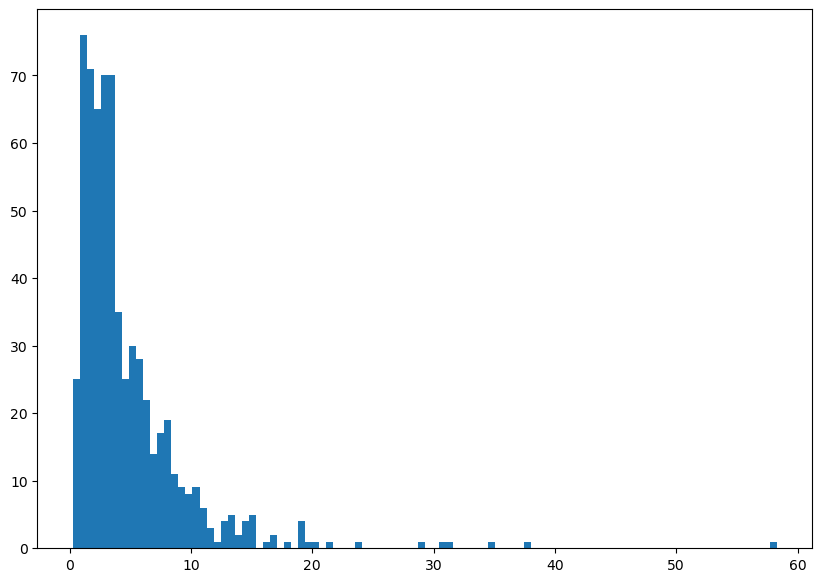

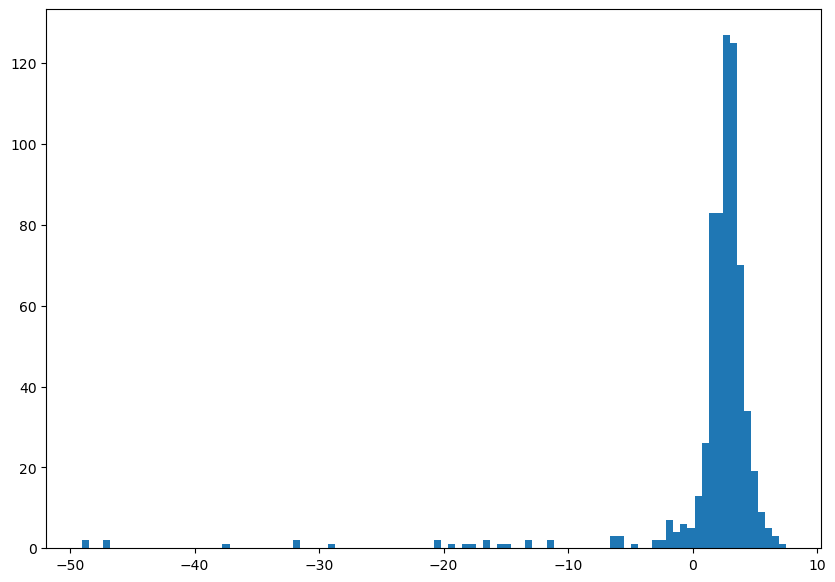

In [201]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)
y_preds = y_preds

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds =2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1

r2 = pearsonr(y_true, y_preds)[0]

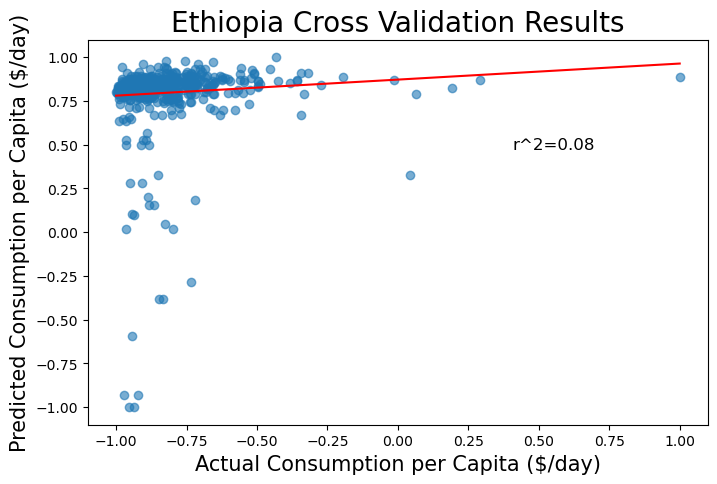

In [202]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([-2, np.max(y_preds)])
plt.show()